<a href="https://colab.research.google.com/github/DomizianoScarcelli/big-data-project/blob/dev/NN_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies

In [1]:
import os
def is_running_on_colab():
    return "COLAB_GPU" in os.environ

LOCAL = not is_running_on_colab()

In [2]:
if not LOCAL:
    !pip install petastorm -qq
    !pip install pyspark -qq
    !pip install -U -q PyDrive -qq
    !apt install openjdk-8-jdk-headless -qq

In [3]:
#@title Imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame, Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType, LongType
from pyspark import SparkContext, SparkConf
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT

from tqdm.notebook import tqdm
import time
import gc

if not LOCAL:
    from google.colab import drive

from typing import Tuple
from functools import reduce
import pickle
import torch
from petastorm import make_batch_reader
from petastorm.pytorch import DataLoader

In [4]:
if not LOCAL:
    drive.mount(GDRIVE_DIR, force_remount=True)

In [5]:
#@title Set up variables
if not LOCAL:
    JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
    GDRIVE_DIR = "/content/drive"
    GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
    GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Big Data/datasets"
    DATASET_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_friendly_spotify_playlist_dataset")
    AUDIO_FEATURES_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_track_features")
    LITTLE_SLICE_FILE = os.path.join(GDRIVE_DATA_DIR, "little_slice")
    SMALL_SLICE_FLIE = os.path.join(GDRIVE_DATA_DIR, "small_slice")
    LITTLE_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "little_slice_audio_features")
    MICRO_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "micro_slice_audio_features")
    SPLITTED_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "splitted_pyspark_track_features")
    SAVED_DFS_PATH = os.path.join(GDRIVE_DATA_DIR, "saved_dfs")
    SAVED_MODELS = os.path.join(GDRIVE_DATA_DIR, "saved_models")
else:
    GDRIVE_DATA_DIR = os.path.abspath("./data")
    SAVED_DFS_PATH = os.path.join(GDRIVE_DATA_DIR, "saved_dfs")
    SAVED_MODELS = os.path.join(GDRIVE_DATA_DIR, "saved_models")
    JAVA_HOME = "/opt/homebrew/opt/openjdk"
RANDOM_SEED = 42 # for reproducibility
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PYSPARK_PYTHON"]="python"

In [6]:
#@title Create the session
config = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '12G').\
                set('spark.driver.memory', '12G').\
                set('spark.driver.maxResultSize', '100G').\
                set("spark.executor.extraJavaOptions", "-XX:+UseG1GC").\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=config)

23/06/16 03:19:30 WARN Utils: Your hostname, MacBook-Air-di-Domiziano.local resolves to a loopback address: 127.0.0.1; using 192.168.1.175 instead (on interface en0)
23/06/16 03:19:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/16 03:19:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark = SparkSession.builder.getOrCreate()

# Data acquisition

In [8]:
playlist_schema_mapped = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", VectorUDT(), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
NUM_PLAYLISTS = 100_000
SONGS_EMBEDDINGS_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-train-{NUM_PLAYLISTS}.json")
SONGS_INFO_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_info_df-{NUM_PLAYLISTS}.json")
SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_vector_length-{NUM_PLAYLISTS}.txt")

ARTIST_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_artist_vector_length-{NUM_PLAYLISTS}.txt")
ARTISTS_EMBEDDINGS_PATH = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-train-{NUM_PLAYLISTS}.json")

In [11]:
# The DF used for train (80% of the original) (playlist are different)
TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"train_df-{NUM_PLAYLISTS}.json")
# The DF used for testing (20% of the original) (playlist are different)
TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"test_df-{NUM_PLAYLISTS}.json")

# The DF used for train in the NN model (can be filtered or not)
NN_TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_train_df-{NUM_PLAYLISTS}.json")
# The DF used for testing in the NN model (can be filtered or not)
NN_TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-{NUM_PLAYLISTS}.json")
# The partition in train test of the NN test set. (Same playlists, different songs)
NN_TEST_DF_TRAIN_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-train-{NUM_PLAYLISTS}.json")
NN_TEST_DF_TEST_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-test-{NUM_PLAYLISTS}.json")

NN_EVAL_PATH = os.path.join(SAVED_DFS_PATH, f"nn_eval_df-{NUM_PLAYLISTS}.json")
NN_EVAL_TRAIN_PATH = os.path.join(SAVED_DFS_PATH, f"nn_eval_df-train-{NUM_PLAYLISTS}.json")
NN_EVAL_TEST_PATH = os.path.join(SAVED_DFS_PATH, f"nn_eval_df-test-{NUM_PLAYLISTS}.json")
# New one:
ARTISTS_EMBEDDINGS_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-test{NUM_PLAYLISTS}.json")

ARTISTS_EMBEDDINGS_EVAL = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-eval-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_EVAL_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-eval-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_EVAL_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-eval-test{NUM_PLAYLISTS}.json")

# The length of the artist vector length (Artist vectors are only used in the NN model)
ARTIST_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_artist_vector_length-{NUM_PLAYLISTS}.txt")

SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"songs_vector_length-{NUM_PLAYLISTS}.txt")
# This may be filtered or not
FILTERED_SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_vector_length-{NUM_PLAYLISTS}.txt")

SONGS_EMBEDDINGS_TRAIN = os.path.join(SAVED_DFS_PATH, f"songs_embeddings-train-{NUM_PLAYLISTS}.json")
SONGS_EMBEDDINGS_TEST = os.path.join(SAVED_DFS_PATH, f"songs_embeddings-test-{NUM_PLAYLISTS}.json")

NN_SONGS_EMBEDDINGS_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-train-{NUM_PLAYLISTS}.json")
NN_SONGS_EMBEDDINGS_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-train-{NUM_PLAYLISTS}.json")
NN_SONGS_EMBEDDINGS_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-test-{NUM_PLAYLISTS}.json")

NN_SONGS_EMBEDDINGS_EVAL = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-eval-{NUM_PLAYLISTS}.json") #TODO: The logic to produce this still has to be coded.
NN_SONGS_EMBEDDINGS_EVAL_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-eval-train-{NUM_PLAYLISTS}.json")
NN_SONGS_EMBEDDINGS_EVAL_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-eval-test-{NUM_PLAYLISTS}.json")

SONGS_INFO_DF = os.path.join(SAVED_DFS_PATH, f"songs_info_df-{NUM_PLAYLISTS}.json")
FILTERED_SONGS_INFO_DF = os.path.join(SAVED_DFS_PATH, f"nn_songs_info_df-{NUM_PLAYLISTS}.json")

In [12]:
songs_embeddings = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH)
artists_embeddings = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH)
song_mapping = spark.read.json(SONGS_INFO_DF_PATH)

songs_embeddings_eval_train = spark.read.schema(playlist_schema_mapped).json(NN_SONGS_EMBEDDINGS_EVAL_TRAIN)
songs_embeddings_eval_test = spark.read.schema(playlist_schema_mapped).json(NN_SONGS_EMBEDDINGS_EVAL_TEST)

artists_embeddings_eval_train = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_EVAL_TRAIN)
artists_embeddings_eval_test = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_EVAL_TEST)

with open(ARTIST_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  ARTIST_VECTOR_LENGTH = int(content) + 1
with open(SONGS_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  SONGS_VECTOR_LENGTH = int(content) + 1

In [13]:
songs_embeddings.show(), artists_embeddings.show(), ARTIST_VECTOR_LENGTH, SONGS_VECTOR_LENGTH

+-------------------+-------------+-----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|               name|collaborative|  pid|modified_at|num_tracks|num_albums|num_followers|              tracks|num_edits|duration_ms|num_artists|
+-------------------+-------------+-----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|              Alone|        false|20080| 1496880000|        50|        48|            1|(681806,[4875,543...|       19|   11128916|         42|
|       Country Hits|        false|14258| 1504828800|       130|        77|            1|(681806,[4,1667,1...|       61|   28245005|         44|
|              Peter|        false|14812| 1446595200|        65|        56|            1|(681806,[214,541,...|       15|   14212644|         47|
|          Rock.....|        false| 1938| 1500163200|        57|        39|            1|(681806,[2909,350...|        5|   1676688

(None, None, 110064, 681806)

# Convert PySpark DataFrame into PyTorch DataLoader

In [14]:
def convert_sparse_to_indices(df: DataFrame, column_name: str) -> DataFrame:
  """
  Given a dataframe fo columns "pos":int and "tracks":SparseVector, it returns a new dataframe where
  the SparseVector are replaced with a list of the indices where the values are.
  (The value information is lost, but we don't care since they are binary values so they will be all ones)
  """

  @F.udf(returnType=ArrayType(IntegerType()))
  def transform_array(item: SparseVector):
    """
    Given a SparseVector (binary) it returns the tuple that represent it, of the type (size, indices)
    """
    indices_list = item.indices.tolist()
    padding_width = max_songs - len(indices_list)
    return indices_list + [-1] * padding_width
  
  max_songs = songs_embeddings.select(F.max("num_tracks")).first()[0]
  print(f"Max number of songs: {max_songs}")
  df = df.withColumn(f"{column_name}_indices", transform_array(F.col(column_name))).drop(column_name)
  return df


In [15]:
def padded_tensors_to_sparse_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    rows.append(sparse_tensor)
  return torch.stack(rows)

def padded_tensors_to_dense_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0) + 1, torch.ones(indices.shape), shape)
    dense = sparse_tensor.to_dense()
    rows.append(dense)
  unpadded = torch.stack(rows)
  return unpadded

In the paper they have two matrices,l et $n$ be the number of unique songs, $m$ the number of playlists and $k$ the number of unique artists:

- $P \in \mathbb{R}^{m \times n}$ where $p_i = 1$ if song $i$ is in the playlist, $p_i=0$ otherwise
- $A \in \mathbb{R}^{m \times k}$ where $a_i=1$ if the artist is present in the playlist, $a_i = 0$ otherwise

In [16]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter

CACHE = os.path.join(GDRIVE_DATA_DIR, "cache")
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df = convert_sparse_to_indices(songs_embeddings.select("tracks", "pid"), column_name="tracks")
# songs_converter = make_spark_converter(pytorch_songs_df)
pytorch_artists_df = convert_sparse_to_indices(artists_embeddings.withColumnRenamed("tracks", "artists").select("pid", "artists"), column_name="artists")
# artist_converter = make_spark_converter(pytorch_artists_df)
songs_artists_df = pytorch_songs_df.join(pytorch_artists_df, on="pid")
pytorch_merged_dataloader = make_spark_converter(songs_artists_df)


print(pytorch_songs_df.count(), pytorch_artists_df.count(), songs_artists_df.count()) #Everything good here, this is nice!

Max number of songs: 250


Converting floating-point columns to float32


Max number of songs: 250


23/06/16 03:19:43 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
The median size 3980660 B (< 50 MB) of the parquet files is too small. Total size: 32581874 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///Users/dov/Desktop/big-data-project/data/cache/20230616031935-appid-local-1686878371467-f57075b6-231c-432d-b7af-f2a27adbecca/part-00001-b0cd3af4-fda4-4915-9766-9dfe4bba7038-c000.parquet, ...


98465 98465 98465


In [17]:
# songs_embeddings.show(), artists_embeddings.show()
# artists_embeddings = artists_embeddings.withColumnRenamed("tracks", "artists").select("pid", "artists")
# df = songs_embeddings.join(artists_embeddings, on="pid").show()

Creating the dataloader for the evaluation set

In [18]:
# pytorch_songs_eval_train_df = convert_sparse_to_indices(songs_embeddings_eval_train.select("tracks", "pid"), column_name="tracks")
# pytorch_artists_eval_train_df = convert_sparse_to_indices(artists_embeddings_eval_train.withColumnRenamed("tracks", "artists").select("pid", "artists"), column_name="artists")
# songs_artists_eval_train_df = pytorch_songs_eval_train_df.join(pytorch_artists_eval_train_df, on="pid")

# pytorch_songs_eval_train_df.orderBy("pid").show(), pytorch_artists_eval_train_df.orderBy("pid").show() #TODO: pid do not match, go to data preparation to fix this


# # songs_artists_eval_train_df.withColumnRenamed("artists_indices", "artists_train_indices").show()

# # songs_artist_eval_train_converter = make_spark_converter(songs_artists_eval_train_df)

# # pytorch_songs_eval_test_df = convert_sparse_to_indices(songs_embeddings_eval_test.select("tracks", "pid"), column_name="tracks")
# # pytorch_artists_eval_test_df = convert_sparse_to_indices(artists_embeddings_eval_test.withColumnRenamed("tracks", "artists").select("pid", "artists"), column_name="artists")
# # songs_artists_eval_test_df = pytorch_songs_eval_test_df.join(pytorch_artists_eval_test_df, on="pid")

# # songs_artist_eval_test_converter = make_spark_converter(songs_artists_eval_test_df)

# PyTorch Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle

class DAE_tied(nn.Module):
    def __init__(self, conf):
        super(DAE_tied, self).__init__()
        self.save_dir = conf["save"]
        # self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = torch.device("mps")
        self.initval_dir = conf["initval"]

        self.n_batch = conf["batch"]
        self.n_input = conf["n_input"]
        self.n_hidden = conf["hidden"]
        self.reg_lambda = conf["reg_lambda"]

        self.keep_prob = torch.tensor(conf["keep_prob"], dtype=torch.float32)
        self.input_keep_prob = torch.tensor(conf["input_keep_prob"], dtype=torch.float32)

        self.weights = {}
        self.biases = {}
        self.d_params = []

        self.z = None

    def init_weight(self):
        if self.initval_dir == 'NULL':
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['encoder_h'])
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
            nn.init.zeros_(self.biases['encoder_b'])
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
            nn.init.zeros_(self.biases['decoder_b'])
        else:
            with open(self.initval_dir, 'rb') as f:
                emb = pickle.load(f)
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(emb[0]).to(self.device))
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(emb[1]).to(self.device))
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(emb[2]).to(self.device))
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(emb[3]).to(self.device))
        self.d_params = [self.weights['encoder_h'], self.weights['encoder_h'], self.biases['encoder_b'], self.biases['decoder_b']]


    # Building the encoder
    def encoder(self, x):
        # Encoder Hidden layer with sigmoid activation #1
        layer = torch.add(torch.matmul(x, self.weights['encoder_h']), self.biases['encoder_b'])
        layer = torch.sigmoid(layer)
        layer = torch.nn.functional.dropout(layer, p=1 - self.keep_prob)

        return layer

    # Building the decoder
    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['encoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
      encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
      decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
      encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2

      l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2
      return l2

    def forward(self, x, y):

        # TODO: Take sparse matrix representation instead of dense
        # self.x = x_positxions
        # self.x_ones = x_ones
        # self.y_positions = y_positions
        # self.y_ones = y_ones

        self.x = x.t()
        self.y = y.t()

        # x_sparse = torch.sparse.FloatTensor(self.x_positions.t(), self.x_ones, torch.Size([self.n_batch, self.n_input]))
        # self.x = x_sparse.to_dense()
        # y_sparse = torch.sparse.FloatTensor(self.y_positions.t(), self.y_ones, torch.Size([self.n_batch, self.n_input]))
        # self.y = y_sparse.to_dense()

        x_dropout = torch.nn.functional.dropout(self.x, p= 1 - self.input_keep_prob)
        reduce_sum = torch.sum(x_dropout, dim=1, keepdim=True)
        self.x_dropout = torch.div(x_dropout, reduce_sum + 1e-10)

        encoder_op = self.encoder(self.x_dropout)

        self.z = encoder_op
        self.y_pred = self.decoder(encoder_op)

        l2 = self.l2_loss()

        L = -torch.sum(self.y * torch.log(self.y_pred + 1e-10) +
                       0.55 * (1 - self.y) * torch.log(1 - self.y_pred + 1e-10), dim=1)
        self.cost = torch.mean(L) + self.reg_lambda * l2

    def save_model(self):
        params = [param.detach().numpy() for param in self.d_params]
        with open(self.save_dir, 'wb') as f:
            pickle.dump(params, f)

            
class DAE(DAE_tied):
    def __init__(self, conf):
        super(DAE, self).__init__(conf)

    def init_weight(self):
        if self.initval_dir == 'NULL':
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['encoder_h'])
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['decoder_h'])
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
            nn.init.zeros_(self.biases['encoder_b'])
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
            nn.init.zeros_(self.biases['decoder_b'])
        else:
            with open(self.initval_dir, 'rb') as f:
                emb = pickle.load(f)
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(emb[0]).to(self.device))
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(emb[1]).to(self.device))
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(emb[2]).to(self.device))
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(emb[3]).to(self.device))

        self.d_params = [self.weights['encoder_h'], self.weights['decoder_h'],
                         self.biases['encoder_b'], self.biases['decoder_b']]

    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['decoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
      encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
      decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
      encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2
      decoder_h_l2 = (torch.sum(self.weights['decoder_h']) ** 2)/2

      l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2 + decoder_h_l2
      return l2

In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

In [21]:
BEST_PARAMS_PATH = os.path.join(SAVED_MODELS, "best_params.pickle")
BEST_PARAMS_PATH_2 = os.path.join(SAVED_MODELS, "best_params_reg.pickle")

#Hyperparameters used in the paper
conf = {
    'batch': 32,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH - 2, #-2 to compense the first row of zeros since the pos in the df start at 1
    'hidden': 200,
    'lr': 0.0001,
    'reg_lambda': 0.0,
    'initval': "NULL",
    "keep_prob": 0.8, 
    "input_keep_prob": 0.8, # This isn't used for now because of the .uniform()
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
pretrain_model = DAE_tied(conf)
pretrain_model.init_weight()
pretrain_model.train()
# optimizer = optim.SGD(dae_model.d_params, lr=conf['lr'], momentum=0.9)

DAE_tied()

In [22]:
pretrain_optimizer = optim.Adam(pretrain_model.d_params, lr=conf['lr'])

In [23]:
pretrain_model.weights['encoder_h'].device

device(type='mps', index=0)

Define the validation function that is invoked during the training in order to save the model parameters that optimize the performance evaluation on the validation set.

In [24]:
from typing import List
def k_prec(eval_preds: torch.Tensor, ground_truth: torch.Tensor, k: torch.Tensor) -> List[float]:
    batch_size = 32
    counts = []

    for i in range(batch_size):
        top_k_preds_idx = eval_preds[i].topk(k[i], dim=0).indices.flatten()
        ground_truth_idx = torch.nonzero(ground_truth[i] == 1).squeeze().flatten()

        common_elements = np.intersect1d(top_k_preds_idx.cpu().detach().numpy(), ground_truth_idx.cpu().detach().numpy())
        num_common_elements = len(common_elements)
        counts.append(num_common_elements)

    return counts

def ndcg(eval_preds: torch.Tensor, ground_truth: torch.Tensor) -> float:
    return 0

def evaluate(eval_preds: torch.Tensor, ground_truth: torch.Tensor, k: torch.Tensor) -> List[float]:
    return k_prec(eval_preds, ground_truth, k)

In [25]:
# def validate(y_preds: torch.Tensor) -> Tuple[float, float]:
#     """
#     Given the model predictions, performs an evaluation on the validation set.
#     """
#     ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
#     SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
#     precs = []
#     tot_k = 0
#     with songs_eval_train_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = 1) as songs_eval_train_dataloader:
#         with artists_eval_train_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = 1) as artist_eval_train_dataloader:
#             with songs_eval_test_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = 1) as songs_eval_test_dataloader:
#                 with artists_eval_test_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = 1) as artist_eval_test_dataloader:
#                     zipped_train_dataloaders = zip(songs_eval_train_dataloader, artist_eval_train_dataloader)
#                     zipped_test_dataloaders = zip(songs_eval_test_dataloader, artist_eval_test_dataloader)

#                     zipped_eval_dataloaders = zip(zipped_train_dataloaders, zipped_test_dataloaders)
#                     pretrain_model.eval()
#                     for batch_idx, ((song_eval_train, artist_eval_train), (song_eval_test, artist_eval_test)) in enumerate(zipped_eval_dataloaders):
#                         with torch.no_grad():
#                             if batch_idx == 1:
#                                 break #TODO: faster but less generalized
#                             padded_eval_song_tensor = song_eval_train["embedding_indices"]
#                             padded_eval_artist_tensor = artist_eval_train["embedding_indices"]
                            
#                             song_dense = padded_tensors_to_dense_matrix(padded_eval_song_tensor, SONG_SHAPE)[:, 1:]
#                             artist_dense = padded_tensors_to_dense_matrix(padded_eval_artist_tensor, ARTIST_SHAPE)[:, 1:]
#                             if (song_dense.shape[0] != 32) or (artist_dense.shape[0] != 32): break #exlude last batch
#                             song_dense = song_dense.to(device)
#                             artist_dense = artist_dense.to(device)

#                             del padded_eval_song_tensor
#                             del padded_eval_artist_tensor
                            
#                             x = torch.concat((song_dense, artist_dense), dim=1).t()
#                             y = torch.concat((song_dense, artist_dense), dim=1).t()
                            
#                             pretrain_model(x, y)

#                             pretrain_model.train()
#                             eval_preds = pretrain_model.y_pred[: SONGS_VECTOR_LENGTH]

#                             padded_eval_song_tensor_test = song_eval_test["embedding_indices"]
                            
#                             ground_truth = padded_tensors_to_dense_matrix(padded_eval_song_tensor_test, SONG_SHAPE)[:, 1:]


#                             ground_truth = ground_truth.to(device)

#                             k = torch.sum(ground_truth == 1, dim=1)
#                             tot_k += torch.sum(k)
#                             prec_list = evaluate(eval_preds, ground_truth, k=k)
#                             precs.extend(prec_list)

#                     pretrain_model.train()
#                     mean_prec = sum(precs) / tot_k
#                     print(f"Precision on validation set is: {mean_prec} on the list {precs}")
#                     return pretrain_model.cost, mean_prec


Testing if the ordering is correct

In [26]:
# from tqdm.notebook import tqdm
# import random
# # os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
# NUM_EPOCHS = 5
# with pytorch_merged_dataloader.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as train_dataloader:
#     ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
#     SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
#     for batch_idx, row in tqdm(enumerate(train_dataloader), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
#       # Pick random input_keep_prob between 0.5 and 0.8
#     #   pretrain_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf
#       pretrain_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

#       padded_song_tensor = row["tracks_indices"]
#       padded_artist_tensor = row["artists_indices"]
      
#       song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
#       artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

#       song_indices = sorted(list(set(torch.nonzero(song_dense[0] == 1).squeeze().flatten().cpu().detach().tolist())))
#       print(torch.nonzero(song_dense[0] == 1))
#       songs_artists_df.show()
#       artist_indices = torch.nonzero(artist_dense == 1).squeeze().flatten()

#     #   print(song_indices)
#     #   print(artist_indices)
#       break


## Train the model

In [27]:
min_loss = 2000
max_prec = 0
best_params = []
losses = []

In [34]:
a = torch.Tensor([[1,3,4,0,0,0], [1,3,5,3,2,1]])
torch.sum(a == 1, dim=1)

tensor([1, 2])

Pretrain with `DAE_tied`

In [28]:
from networkx import max_weight_clique
from tqdm.notebook import tqdm
import random
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
NUM_EPOCHS = 2
with pytorch_merged_dataloader.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as train_dataloader:
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    for batch_idx, row in tqdm(enumerate(train_dataloader), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
    #   pretrain_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf
      pretrain_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = row["tracks_indices"]
      padded_artist_tensor = row["artists_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        pretrain_optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        pretrain_model(x, y)
        loss = pretrain_model.cost
        pretrain_model.cost.backward()
        pretrain_optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        pretrain_optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        pretrain_model(x, y)
        loss = pretrain_model.cost
        pretrain_model.cost.backward()
        pretrain_optimizer.step()

      losses.append(loss)
     
    #   if loss < min_loss:
    #     min_loss = loss
    #     del best_params
    #     best_params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
    #     with open(BEST_PARAMS_PATH, "wb") as f:
    #       pickle.dump(best_params, f)
    #     print(f"Best loss achieved: {min_loss}, parameters saved!")

      if batch_idx % 100 == 0:
        print(f"Loss: {loss}")
        # print(f"z: ", pretrain_model.z)
        k = torch.sum(y == 1, dim=1)
        counts = evaluate(pretrain_model.y_pred, y.t(), k)
        print("Precisions: ", torch.tensor(counts)/k.cpu())
        # if batch_idx != 0:
            # eval_loss, prec = validate(pretrain_model.y_pred)
            # print("Validation loss: ", eval_loss)
            
            # # if prec > max_prec:
            #     # max_prec = prec
            #     # best_params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
            #     # with open(BEST_PARAMS_PATH, "wb") as f:
            #         # pickle.dump(best_params, f)
            #     # print(f"Best prec achieved: {prec}, parameters saved!")
            # if eval_loss < min_loss:
            #     min_loss = eval_loss
            #     del best_params
            #     best_params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
            #     with open(BEST_PARAMS_PATH, "wb") as f:
            #         pickle.dump(best_params, f)
            #     print(f"Best loss achieved: {eval_loss}, parameters saved!")

Training model:   0%|          | 0/6250.0 [00:00<?, ?it/s]

Loss: 301918.4375
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 82138.40625
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 37576.5234375
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 20032.7109375
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 13271.50390625
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 9078.171875
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 7211.185546875
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Loss: 5630.58203125
Precisions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

KeyboardInterrupt: 

In [29]:
params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
with open(BEST_PARAMS_PATH_2, 'wb') as f:
  pickle.dump(params, f)

Train with `DAE` loading the pretrained `DAE_tied` model

In [ ]:
conf = {
    'batch': 250,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH - 2, #-2 to compense the first row of zeros since the pos in the df start at 1
    'hidden': 256,
    'lr': 0.00005,
    'reg_lambda': 0.0,
    'initval': BEST_PARAMS_PATH,
    "keep_prob": 0.8, 
    "input_keep_prob": 0.8, # This isn't used for now because of the .uniform()
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
dae_model = DAE(conf)
dae_model.init_weight()
optimizer = optim.Adam(dae_model.d_params, lr=conf['lr'])

min_loss = 600
losses = []
best_params = []
FINE_TUNED_BEST_PARAMS_PATH = os.path.join(SAVED_MODELS, "final_best_params.pickle")

In [ ]:
from tqdm.notebook import tqdm
import random
NUM_EPOCHS = 20
with songs_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as songs_dataloader:
  with artist_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as artists_dataloader:
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    # for epoch in tqdm(range(num_epochs), desc="Training..."):
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
      dae_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()

      losses.append(loss)

     
      if loss < min_loss:
        min_loss = loss
        del best_params
        best_params = [param.cpu().detach().numpy() for param in dae_model.d_params]
        with open(FINE_TUNED_BEST_PARAMS_PATH, "wb") as f:
          pickle.dump(best_params, f)
        print(f"Best loss achieved: {min_loss}, parameters saved!")

      if batch_idx % 10 == 0:
        print(f"Loss: {loss}")


Let's see how the loss decreases

In [ ]:
SAVE_MODEL_PATH = os.path.join(SAVED_DFS_PATH, f"model_new.pickle")
params = [param.cpu().detach().numpy() for param in dae_model.d_params]
with open(SAVE_MODEL_PATH, 'wb') as f:
  pickle.dump(params, f)

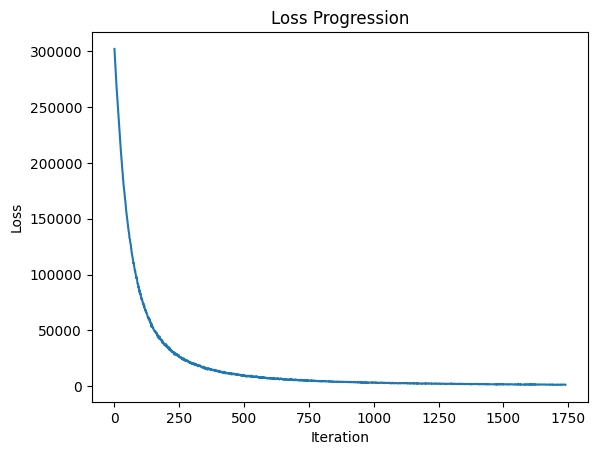

In [30]:
import matplotlib.pyplot as plt
x = np.arange(len(losses))
plt.plot(x, [loss.item() for loss in losses])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.show()

# Inference

In [ ]:
from pyspark.ml.linalg import VectorUDT
song_schema = StructType([
    StructField("pos", IntegerType(), True),
    StructField("artist_name", StringType(), True),
    StructField("track_uri", StringType(), True),
    StructField("artist_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("album_uri", StringType(), True),
    StructField("duration_ms", LongType(), True),
    StructField("album_name", StringType(), True)
])

playlist_schema = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", ArrayType(song_schema), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])

In [ ]:
SONGS_EMBEDDINGS_PATH_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-train-{NUM_PLAYLISTS}.json")
SONGS_EMBEDDINGS_PATH_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-test-{NUM_PLAYLISTS}.json")

ARTISTS_EMBEDDINGS_PATH_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_PATH_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-test-{NUM_PLAYLISTS}.json")

songs_embeddings_test_train = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH_TEST_TRAIN)
songs_embeddings_test_test = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH_TEST_TEST)

artists_embeddings_test_train = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH_TEST_TRAIN)
artists_embeddings_test_test = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH_TEST_TEST)

TEST_TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-train-{NUM_PLAYLISTS}.json")
TEST_TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-test-{NUM_PLAYLISTS}.json")

test_train_df = spark.read.schema(playlist_schema).json(TEST_TRAIN_DF_PATH)
test_test_df = spark.read.schema(playlist_schema).json(TEST_TEST_DF_PATH)

In [ ]:
def construct_prediction_df(prediction: torch.Tensor, mapping: DataFrame, top_n: int = 50) -> DataFrame:
  pred_np = prediction.detach().numpy()
  indexes = np.arange(pred_np.shape[0]) # To compensate the index start at 1
  schema = StructType([
      StructField("pos", IntegerType()),
      StructField("confidence", FloatType())
  ])
  prediction_df = spark.createDataFrame([(pos, conf) for pos, conf in zip(indexes.tolist(), pred_np.tolist())],schema)
  prediction_info = prediction_df.join(mapping, "pos")
  return prediction_info

# prediction_df = construct_prediction_df(prediction, songs_df_test)
# prediction_df.show()

In [ ]:
def remove_existing_tracks(playlist_tracks: DataFrame, recommendations_df: DataFrame) -> DataFrame:
  playlist_tracks = playlist_tracks.select("track_uri").cache()
  playlist_tracks_compatible = playlist_tracks.join(F.broadcast(recommendations_df), on="track_uri")
  playlist_tracks.unpersist()
  return recommendations_df.exceptAll(F.broadcast(playlist_tracks_compatible))

# Evaluation

In [ ]:
def precision_at_k(recommendations, ground_truth, num_of_recommendations) -> float:
    """
    Calculates precision at k for the recommendations.
    """
    recommended_relevant_tracks = recommendations.join(ground_truth, "track_uri").cache()
    reccomended_relevant_tracks_count = recommended_relevant_tracks.count() #this can be top_n_results.join in order to be more performant
    recommended_relevant_tracks.unpersist()
    precision = reccomended_relevant_tracks_count / float(num_of_recommendations)

    return precision


import math
def normalized_discounted_cumulative_gain(recommendations: DataFrame, ground_truth: DataFrame, num_of_recommendations: int) -> float:
  recommendations_list = recommendations.collect()
  cumulative_gain = 0

  intersection = recommendations.join(ground_truth, "track_uri").count()
  if intersection == 0: return 0

  ideal_cumulative_gain = 1 + np.array([(1 / math.log(i, 2)) for i in range(2, 2+intersection)]).sum() #TODO: replace this with sum([])
  for index, row in enumerate(recommendations_list):
    i = index + 1
    is_rel = ground_truth.filter(F.col("track_uri").isin(row.track_uri)).count() > 0
    rel = 1 if is_rel else 0
    if i == 1:
      cumulative_gain += rel
    else:
      cumulative_gain += (rel / math.log(i, 2))
  return cumulative_gain / ideal_cumulative_gain

Creating the dataloaders for the test set

In [ ]:
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df_test = convert_sparse_to_indices(songs_embeddings_test_train.select("tracks"))
songs_converter_test = make_spark_converter(pytorch_songs_df_test)

pytorch_artists_df_test = convert_sparse_to_indices(artists_embeddings_test_train.select("tracks"))
artist_converter_test = make_spark_converter(pytorch_artists_df_test)

Converting floating-point columns to float32                                    


Max number of songs: 250


The median size 137021 B (< 50 MB) of the parquet files is too small. Total size: 233150 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///Users/dov/Desktop/big-data-project/data/cache/20230613203504-appid-local-1686674016052-044c5a3b-7e2e-4703-bde1-c5581a209825/part-00001-2209ea1f-fd7e-4e79-b87b-e7b847d72234-c000.parquet, ...
Converting floating-point columns to float32


Max number of songs: 250


The median size 19056 B (< 50 MB) of the parquet files is too small. Total size: 134516 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///Users/dov/Desktop/big-data-project/data/cache/20230613203506-appid-local-1686674016052-989e6c66-19d3-4e2c-9408-5bb7a5ea72a5/part-00000-c95c506b-0a0b-41e6-8a3b-3a5d31d76cac-c000.parquet, ...


In [ ]:
#Hyperparameters used in the paper
conf = {
    'batch': 32,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH - 2, #-2 to compense the first row of zeros since the pos in the df starts at 1,
    'hidden': 50,
    'lr': 0.001, #original 0.001
    'reg_lambda': 0.0,
    'initval': BEST_PARAMS_PATH, #TODO: change it in fine_tuned path
    "keep_prob": 1,
    "input_keep_prob": 1,
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
dae_model_test = DAE(conf)
dae_model_test.init_weight()
dae_model_test.eval()

DAE()

In [ ]:
ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
with songs_converter_test.make_torch_dataloader(batch_size=conf["batch"], num_epochs =1) as songs_dataloader:
  with artist_converter_test.make_torch_dataloader(batch_size=conf["batch"], num_epochs=1) as artists_dataloader:
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Evaluation...", total= (NUM_PLAYLISTS / conf["batch"])):
      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      x = torch.concat((song_dense, artist_dense), dim=1).t()
      y = torch.concat((song_dense, artist_dense), dim=1).t()
      
      dae_model_test(x,y)
      
      result = dae_model_test.y_pred
      break

Evaluation...:   0%|          | 0/3125.0 [00:00<?, ?it/s]

In [ ]:
result

tensor([[0.0261, 0.0018, 0.0084,  ..., 0.0003, 0.0004, 0.0004],
        [0.0270, 0.0019, 0.0088,  ..., 0.0003, 0.0004, 0.0004],
        [0.0272, 0.0019, 0.0089,  ..., 0.0003, 0.0004, 0.0004],
        ...,
        [0.0292, 0.0022, 0.0098,  ..., 0.0004, 0.0005, 0.0005],
        [0.0262, 0.0018, 0.0084,  ..., 0.0003, 0.0004, 0.0004],
        [0.0264, 0.0018, 0.0086,  ..., 0.0003, 0.0004, 0.0004]],
       device='mps:0', grad_fn=<SigmoidBackward0>)

In [ ]:
# torch.concat((song_dense[:, 1:], artist_dense[:, 1:]), dim=1).t().shape
# (song_dense[:, 0] == 0.).all(), (artist_dense[:, 0] == 0.).all()

In [ ]:
# result = result.to("cpu")
# prediction_df = construct_prediction_df(result[10][:SONGS_VECTOR_LENGTH_TEST], songs_df_test, 20)

In [ ]:
# prediction_df.orderBy("pos").show(truncate=False)
# songs_df_test.show()

In [ ]:
# def evaluate_batch(batch_result: torch.Tensor, batch_n: int) -> Tuple[float, float]:
#   """
#   Returns the precision and NDCG for a given batch.
#   """
  
#   return 0,0

# def perform_evaluation(songs_dataloader, artists_dataloader, test_set):
#   """
#   Returns the precision and NDCG, averaged from all the samples in the test set
#   """
#   with songs_converter_test.make_torch_dataloader(num_epochs =1) as songs_dataloader:
#     with artist_converter_test.make_torch_dataloader(num_epochs=1) as artists_dataloader:
#       zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
#       for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Evaluation...", total= (NUM_PLAYLISTS / 32) * NUM_EPOCHS):
#         padded_song_tensor = song["embedding_indices"]
#         padded_artist_tensor = artist["embedding_indices"]
        
#         song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
#         artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

#         x = torch.concat((song_dense, artist_dense), dim=1).t()
#         y = torch.concat((song_dense, artist_dense), dim=1).t()
#         dae_model(x,y)
#         batch_result = dae_model.y_pred
#         break


In [ ]:
#Testing the first batch

results = []
# for i in tqdm(range(32)):
PID = 71860
ground_truth = test_test_df.filter(F.col("pid") == PID).select(F.explode("tracks")).select("col.*")
playlist_train_songs = test_train_df.filter(F.col("pid") == PID).select(F.explode("tracks")).select("col.*")

#Removing rare songs (that the model didn't consider)
#This may be not the best approach since the train songs or ground truth may become 0
clean_ground_truth = ground_truth.join(song_mapping, on="track_uri").cache()
clean_playlist_train_songs = playlist_train_songs.join(song_mapping, on="track_uri").cache()

# n_recommendations = ground_truth.count() or 1
n_recommendations = 500
result = result.cpu()

#The result[i] has to be aligned with the PID. i != PID. 
prediction_df = construct_prediction_df(result[1][:SONGS_VECTOR_LENGTH], song_mapping, n_recommendations).cache()
clean_prediction_df = remove_existing_tracks(clean_playlist_train_songs, prediction_df)

clean_prediction_df = prediction_df.orderBy(F.col("confidence").desc()).limit(n_recommendations).cache()

prec = precision_at_k(clean_prediction_df, clean_ground_truth, n_recommendations)
gain = normalized_discounted_cumulative_gain(clean_prediction_df, clean_ground_truth, n_recommendations)
print(PID, prec, gain)
results.append((prec, gain))

ground_truth.unpersist()
clean_ground_truth.unpersist()
playlist_train_songs.unpersist()
clean_playlist_train_songs.unpersist()
prediction_df.unpersist()
clean_prediction_df.unpersist()

23/06/13 20:36:00 WARN TaskSetManager: Stage 35 contains a task of very large size (1209 KiB). The maximum recommended task size is 1000 KiB.


71860 0.0 0


DataFrame[pos: int, confidence: float, track_uri: string]

In [ ]:
print("Playlist train songs")
playlist_train_songs.show(truncate=False)
print("Clean playlist train songs")
clean_playlist_train_songs.show(truncate=False)
print("Ground truth songs")
ground_truth.show(truncate=False)
print("Clean ground truth songs")
clean_ground_truth.show(truncate=False)
print(f"Prediction df songs (num recommendations: {n_recommendations})")
prediction_df.show(truncate=False)
print(f"Clean Prediction df songs (num recommendations: {n_recommendations})")
clean_prediction_df.show(truncate=False)
prec, gain

Playlist train songs
+---+-------------+------------------------------------+-------------------------------------+---------------------------------------------------------------+------------------------------------+-----------+-----------------+
|pos|artist_name  |track_uri                           |artist_uri                           |track_name                                                     |album_uri                           |duration_ms|album_name       |
+---+-------------+------------------------------------+-------------------------------------+---------------------------------------------------------------+------------------------------------+-----------+-----------------+
|17 |MIKA         |spotify:track:6AviHKu3ydzAePBmzEi62v|spotify:artist:5MmVJVhhYKQ86izuGHzJYA|Popular Song                                                   |spotify:album:6czdbbMtGbAkZ6ud2OMTcg|200213     |Yours Truly      |
|8  |Ariana Grande|spotify:track:6EIsMa5lbvljYxqCkjZVDi|spotify:artist:66CX

23/06/13 20:36:18 WARN TaskSetManager: Stage 66 contains a task of very large size (1209 KiB). The maximum recommended task size is 1000 KiB.
23/06/13 20:36:19 WARN TaskSetManager: Stage 71 contains a task of very large size (1209 KiB). The maximum recommended task size is 1000 KiB.


+---+------------+------------------------------------+
|pos|confidence  |track_uri                           |
+---+------------+------------------------------------+
|7  |0.0051272963|spotify:track:48ZUwXrEOhaXLCxvmRYhZv|
|19 |0.0037515892|spotify:track:4eQec76xYzMWafPfJEDELl|
|22 |4.4842117E-4|spotify:track:0srm8RgwUfBvwdXKvkyDlT|
|26 |0.015324642 |spotify:track:6G6u99wgTtoATpqtNmA02F|
|29 |0.00205158  |spotify:track:3cwDSDzTiWr5H5xMQhQ6Mx|
|34 |0.006128149 |spotify:track:2X9G82BPPSqhE78e5YjekE|
|50 |4.309273E-4 |spotify:track:35k31HZI4z9PbBOioaI4dZ|
|54 |8.9117774E-4|spotify:track:6iX1f3r7oUJnMbGgQ2gx1j|
|57 |0.0011192594|spotify:track:0C1OcBOsuFmFFGkh3FWIGG|
|65 |0.0026256384|spotify:track:4bEcoz1OcfMgUbp2ft8ieQ|
|77 |2.4645153E-4|spotify:track:4Fvnz1ZJ86IdqDAepWYPAh|
|94 |2.4668826E-4|spotify:track:6HEAUuBSW9lCL4clfEOTJ8|
|110|2.5660856E-4|spotify:track:65lHwG8JFJs67PnOUhCYPq|
|112|5.3823285E-4|spotify:track:1UlyHfT68gEVYwIMIVEX1u|
|113|0.0024502387|spotify:track:7EgG37pjxw0Y4GHw

+------+-----------+------------------------------------+
|pos   |confidence |track_uri                           |
+------+-----------+------------------------------------+
|681805|0.1904341  |spotify:track:7AbAfIqrkrWHwSF32eemMV|
|23173 |0.1091218  |spotify:track:6DjEa4vziZjdYG0bq2Jxcl|
|348871|0.099217884|spotify:track:539wfGOsGcRmT1IBVUfiJV|
|338336|0.09756852 |spotify:track:0zMzyHAeMvwq5CRstru1Fp|
|30442 |0.0918417  |spotify:track:4z0PnuB07fxtVZZRWsCfxb|
|28061 |0.09160706 |spotify:track:2gdEfFFTRU8ylaqteESdk2|
|36914 |0.082439065|spotify:track:5JDcQAztvZTIkrWoZihgvC|
|367112|0.08186953 |spotify:track:5SECgk6Gf1TVMy2FApJmSO|
|376243|0.08050343 |spotify:track:3cqZH3cqvfbV8wVbvHyPbG|
|29257 |0.079650715|spotify:track:0SGkqnVQo9KPytSri1H6cF|
|355820|0.07798547 |spotify:track:1SN1gifVAKecU85lZggS8k|
|366732|0.075138435|spotify:track:66hayvUbTotekKU3H4ta1f|
|348084|0.07473964 |spotify:track:6SwRhMLwNqEi6alNPVG00n|
|38126 |0.07468223 |spotify:track:4TshxhRTfQqDhQbXmTvY50|
|21166 |0.0745

(0.0, 0)

In [ ]:
def average_results(results):
  prec_avg = sum(prec for prec, _ in results) / len(results)
  gain_avg = sum(gain for _, gain in results) / len(results)
  return prec_avg, gain_avg

average_results(results)